<a href="https://colab.research.google.com/github/Shakib-IO/Knowledge_distillation/blob/main/BiggerResNet_Knowledge_distill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check the folder
!ls

drive  sample_data


**Import Libraries**

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

import time

In [ ]:
# Keras & Tensorflow
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

**Load the Dataset as Numpy array file**

In [ ]:
benign_train = np.load('/content/drive/MyDrive/CSE499/numpy/benign_train.npy')
malign_train = np.load('/content/drive/MyDrive/CSE499/numpy/malign_train.npy')
benign_test = np.load('/content/drive/MyDrive/CSE499/numpy/benign_test.npy')
malign_test = np.load('/content/drive/MyDrive/CSE499/numpy/malign_test.npy')
print('Done Loaded :)')

Done Loaded :)


In [ ]:
#Shape of our dataset
print(f'Benign Train:',benign_train.shape)
print(f'Malignant Train',malign_train.shape)
print(f'Benign Test:',benign_test.shape)
print(f'Malignant Test',malign_test.shape)

Benign Train: (3500, 224, 224, 3)
Malignant Train (3496, 224, 224, 3)
Benign Test: (1500, 224, 224, 3)
Malignant Test (1500, 224, 224, 3)


**Visualization**

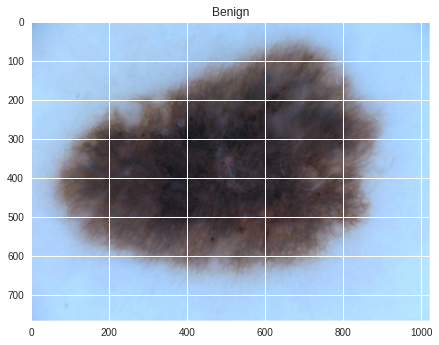

In [ ]:
im = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/benign/ISIC_0000000.jpeg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title('Benign')
plt.show()

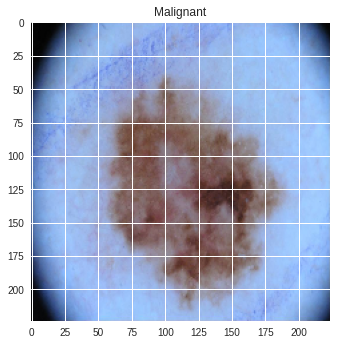

In [ ]:
im = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/malignant/ISIC_0000002.jpeg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.title('Malignant')
plt.show()

**Create Label for each class 0.0 = Benign , 1.0 = malignant**

In [ ]:
benign_train_label = np.zeros(len(benign_train),dtype=float)
malign_train_label = np.ones(len(malign_train),dtype=float)
benign_test_label = np.zeros(len(benign_test),dtype=float)
malign_test_label = np.ones(len(malign_test),dtype=float) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
print(f'X train shape:',X_train.shape)
print(f'X test shape:',X_test.shape)
print(f'Y train shape:',Y_train.shape)
print(f'Y test shape:',Y_test.shape)

X train shape: (6996, 224, 224, 3)
X test shape: (3000, 224, 224, 3)
Y train shape: (6996, 2)
Y test shape: (3000, 2)


**Split the Train and Valid**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

In [ ]:
print(f'x train shape:',x_train.shape)
print(f'x val shape:',x_val.shape)
print(f'y train shape:',y_train.shape)
print(f'y val shape:',y_val.shape)

x train shape: (5596, 224, 224, 3)
x val shape: (1400, 224, 224, 3)
y train shape: (5596, 2)
y val shape: (1400, 2)


**Let's display Some images**

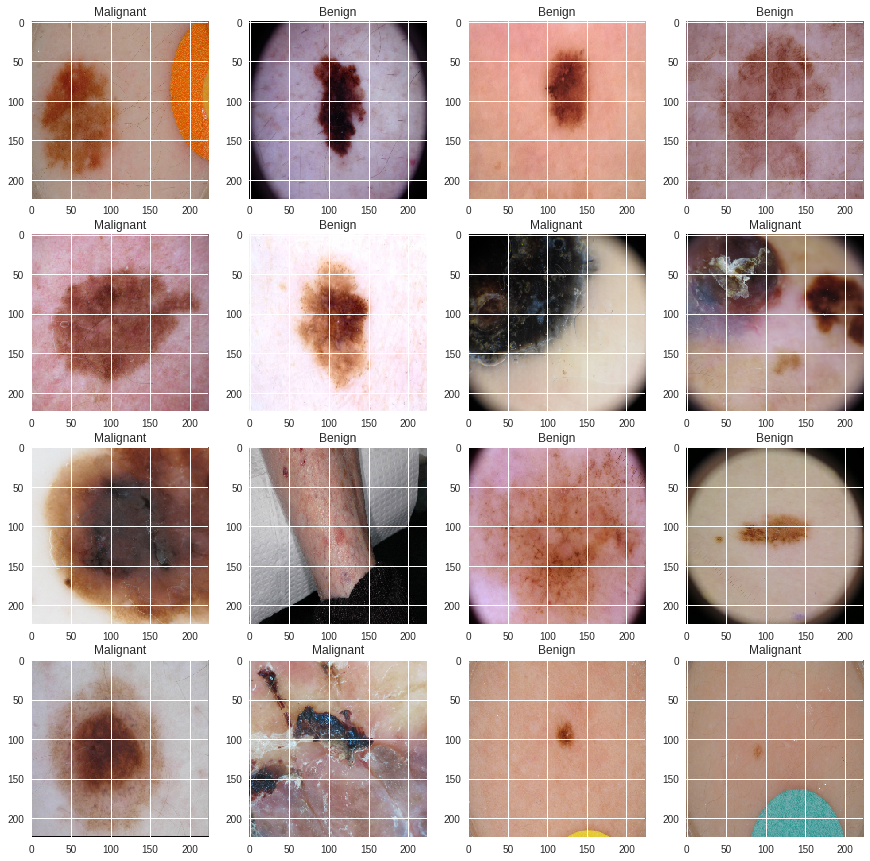

In [ ]:
w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows +1): 
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0.0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

**ResNet50 as a Teacher model**

In [ ]:
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2 , activation='softmax'))
  
  model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return model

resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224 , 224 , 3)
)
#call the model 
model = build_model(resnet , lr = 1e-4)
model.build((None, 224, 224, 3))
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


**Training the teacher model with Resnet50**

In [ ]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
epochs = 10
batch_size = 64
teacher_his = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/10
88/88 [==============================] - 110s 663ms/step - loss: 0.3050 - accuracy: 0.8867 - val_loss: 0.1255 - val_accuracy: 0.9500
Epoch 2/10
88/88 [==============================] - 57s 643ms/step - loss: 0.0662 - accuracy: 0.9749 - val_loss: 0.1254 - val_accuracy: 0.9593
Epoch 3/10
88/88 [==============================] - 58s 661ms/step - loss: 0.0491 - accuracy: 0.9823 - val_loss: 0.1061 - val_accuracy: 0.9579
Epoch 4/10
88/88 [==============================] - 58s 657ms/step - loss: 0.0489 - accuracy: 0.9802 - val_loss: 0.1594 - val_accuracy: 0.9607
Epoch 5/10
88/88 [==============================] - 58s 659ms/step - loss: 0.0176 - accuracy: 0.9958 - val_loss: 0.1554 - val_accuracy: 0.9607
Epoch 6/10
88/88 [==============================] - 58s 660ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.2648 - val_accuracy: 0.9479
Epoch 7/10
88/88 [==============================] - 58s 659ms/step - loss: 0.0188 - accuracy: 0.9939 - val_loss: 0.4037 - val_accuracy: 0.947

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [ ]:
Y_val_pred = model.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The Teacher model Accuracy on the Validation Set: 0.9678571428571429


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[9.9999714e-01 2.8538791e-06]
 [1.0000000e+00 3.9821440e-08]
 [1.5809531e-13 1.0000000e+00]
 ...
 [1.0000000e+00 1.8316412e-09]
 [4.0680415e-04 9.9959320e-01]
 [2.6661828e-08 1.0000000e+00]]

Time:  10.26257694900005 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Teacher model with ResNet50 on the Test set is: 0.998


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)

from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)


# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

-------

**Student model**

**ResNet100**

In [ ]:
from tensorflow.keras.applications import ResNet101

def res_model101(backbone , lr = 1e-4):
  resmodel101 = Sequential()
  resmodel101.add(backbone)
  resmodel101.add(layers.GlobalAveragePooling2D())
  resmodel101.add(layers.Dropout(0.5))
  resmodel101.add(layers.BatchNormalization())
  resmodel101.add(layers.Dense(2 , activation='softmax'))
  
  resmodel101.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return resmodel101


resenet101 = ResNet101(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model 
resmodel101 = res_model101(resenet101 , lr = 1e-4)
resmodel101.build((None, 224, 224, 3))
resmodel101.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 7, 7, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 42,670,466
Trainable params: 42,561,026
Non-trainable params: 109,440
_________________________________________________________________


**Temperature = 10**

In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets
#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

[[0.7310586 0.2689414]]




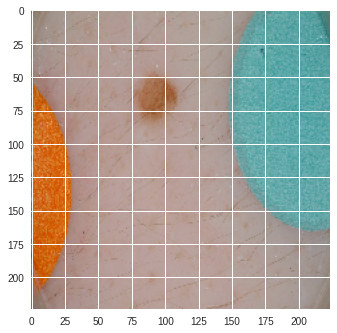

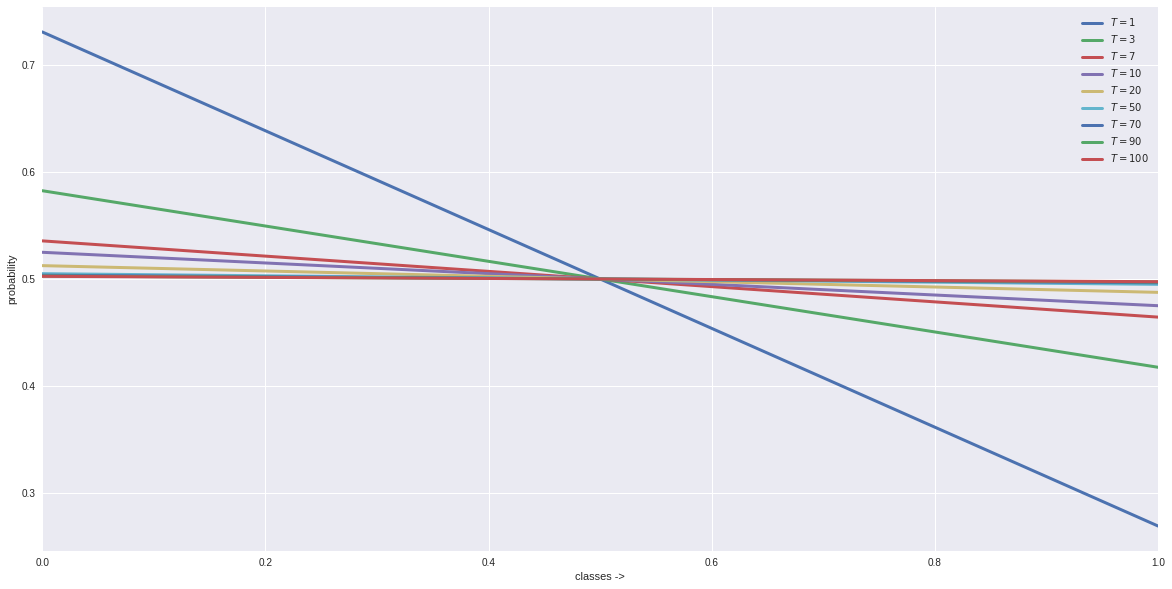

In [ ]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(x_train[122].reshape(1,224,224,3))
print(softmax(intermediate_output))
print('\n')

pixels = x_train[122]
pixels = pixels.reshape((224, 224, 3))
plt.imshow(pixels)
plt.show()
print('\n')

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize = (20, 10));

temperature = [1,3,7,10,20,50,70,90,100]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=3);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 1]);
plt.show()

In [ ]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
resmodel101.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = resmodel101.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model as mobileNet
resmodel101 = Model(resmodel101.input, output)

resmodel101.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
module_wrapper_2_input (InputLa [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
module_wrapper_2 (ModuleWrapper (None, 7, 7, 2048)   42658176    module_wrapper_2_input[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           module_wrapper_2[0][0]           
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           global_average_pooling2d_2[0][0] 
____________________________________________________________________________________________

**Distill Loss Function**

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function
nb_classes = 2
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

resmodel101.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] 
  )

In [ ]:
# Train the student model with Resnet101
epochs = 20
batch_size = 64
resmodel101_student_his = resmodel101.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 110s 1s/step - loss: 0.0657 - acc: 0.6145 - val_loss: 0.0581 - val_acc: 0.7407
Epoch 2/20
88/88 [==============================] - 98s 1s/step - loss: 0.0633 - acc: 0.6438 - val_loss: 0.0563 - val_acc: 0.7643
Epoch 3/20
88/88 [==============================] - 98s 1s/step - loss: 0.0610 - acc: 0.6751 - val_loss: 0.0538 - val_acc: 0.7993
Epoch 4/20
88/88 [==============================] - 98s 1s/step - loss: 0.0579 - acc: 0.7132 - val_loss: 0.0519 - val_acc: 0.8286
Epoch 5/20
88/88 [==============================] - 98s 1s/step - loss: 0.0563 - acc: 0.7463 - val_loss: 0.0504 - val_acc: 0.8450
Epoch 6/20
88/88 [==============================] - 98s 1s/step - loss: 0.0540 - acc: 0.7713 - val_loss: 0.0488 - val_acc: 0.8643
Epoch 7/20
88/88 [==============================] - 98s 1s/step - loss: 0.0532 - acc: 0.7782 - val_loss: 0.0476 - val_acc: 0.8764
Epoch 8/20
88/88 [==============================] - 98s 1s/step - loss: 0.0523 - acc: 0.7

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(resmodel101_student_his.history['acc'])
plt.plot(resmodel101_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(resmodel101_student_his.history['loss'])
plt.plot(resmodel101_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [ ]:
Y_val_pred = resmodel101.predict(x_val)
print(f'The ResNet101 model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The ResNet101 model Accuracy on the Validation Set: 0.9242857142857143


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = resmodel101.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.7220391  0.2779609  0.52384686 0.47615314]
 [0.72816324 0.27183682 0.5246132  0.47538683]
 [0.34326312 0.6567369  0.48378602 0.51621395]
 ...
 [0.7302032  0.26979682 0.5248708  0.4751292 ]
 [0.31480408 0.6851959  0.48056594 0.5194341 ]
 [0.29778415 0.70221585 0.47856635 0.52143365]]

Time:  14.547594188999938 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Student model with ResNet101 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Student model with ResNet101 on the Test set is: 0.9963333333333333


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1500
           1       0.99      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)


# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

---


**ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50

def res_model50(backbone , lr = 1e-4):
  resmodel50 = Sequential()
  resmodel50.add(backbone)
  resmodel50.add(layers.GlobalAveragePooling2D())
  resmodel50.add(layers.Dropout(0.5))
  resmodel50.add(layers.BatchNormalization())
  resmodel50.add(layers.Dense(2 , activation='softmax'))
  
  resmodel50.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return resmodel50


resenet50 = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model 
resmodel50 = res_model50(resenet50 , lr = 1e-4)
resmodel50.build((None, 224, 224, 3))
resmodel50.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_5 (ModuleWrap (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

[[0.7310586 0.2689414]]




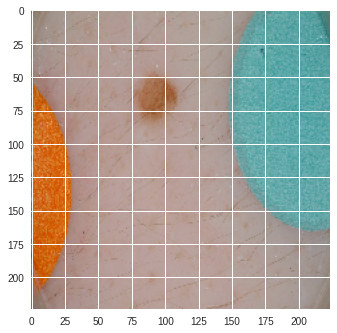

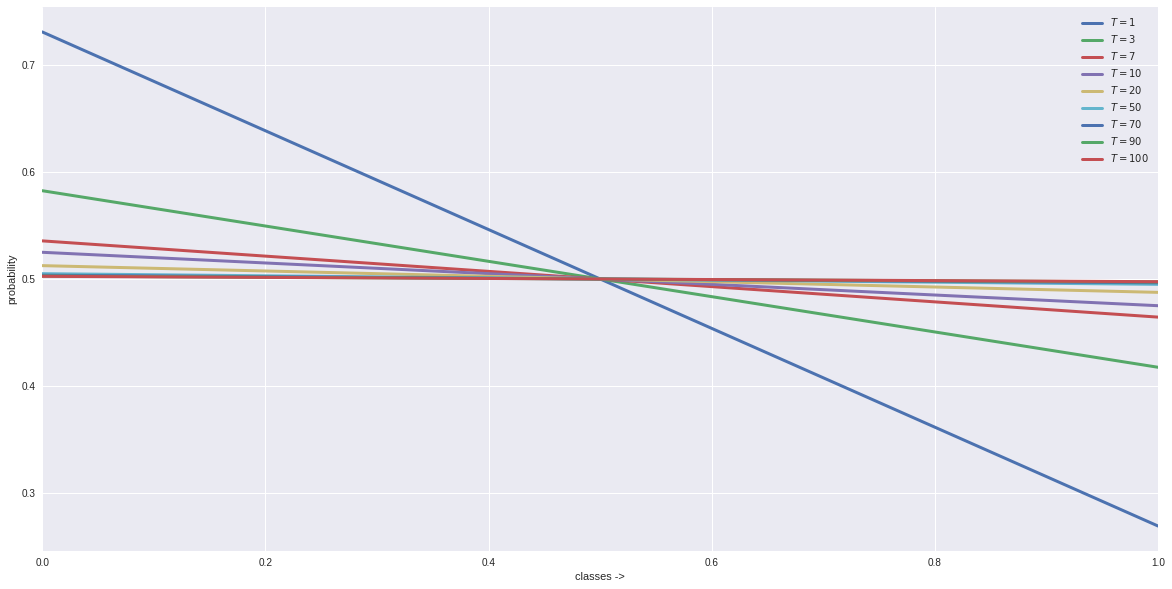

In [ ]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(x_train[122].reshape(1,224,224,3))
print(softmax(intermediate_output))
print('\n')

pixels = x_train[122]
pixels = pixels.reshape((224, 224, 3))
plt.imshow(pixels)
plt.show()
print('\n')

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize = (20, 10));

temperature = [1,3,7,10,20,50,70,90,100]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=3);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 1]);
plt.show()

In [ ]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
resmodel50.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = resmodel50.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model as mobileNet
resmodel50 = Model(resmodel50.input, output)

resmodel50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
module_wrapper_5_input (InputLa [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
module_wrapper_5 (ModuleWrapper (None, 7, 7, 2048)   23587712    module_wrapper_5_input[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 2048)         0           module_wrapper_5[0][0]           
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           global_average_pooling2d_5[0][0] 
____________________________________________________________________________________________

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function
nb_classes = 2
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

resmodel50.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] 
  )

In [ ]:
# Train the student model with ResNet50
epochs = 20
batch_size = 64
resmodel50_student_his = resmodel50.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 63s 658ms/step - loss: 0.0689 - acc: 0.5735 - val_loss: 0.0621 - val_acc: 0.6814
Epoch 2/20
88/88 [==============================] - 58s 663ms/step - loss: 0.0643 - acc: 0.6416 - val_loss: 0.0581 - val_acc: 0.7421
Epoch 3/20
88/88 [==============================] - 58s 660ms/step - loss: 0.0615 - acc: 0.6705 - val_loss: 0.0547 - val_acc: 0.7929
Epoch 4/20
88/88 [==============================] - 58s 661ms/step - loss: 0.0593 - acc: 0.7049 - val_loss: 0.0518 - val_acc: 0.8336
Epoch 5/20
88/88 [==============================] - 58s 659ms/step - loss: 0.0566 - acc: 0.7339 - val_loss: 0.0495 - val_acc: 0.8600
Epoch 6/20
88/88 [==============================] - 58s 660ms/step - loss: 0.0546 - acc: 0.7684 - val_loss: 0.0479 - val_acc: 0.8807
Epoch 7/20
88/88 [==============================] - 58s 661ms/step - loss: 0.0530 - acc: 0.7895 - val_loss: 0.0466 - val_acc: 0.8850
Epoch 8/20
88/88 [==============================] - 58s 661ms/step - 

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(resmodel50_student_his.history['acc'])
plt.plot(resmodel50_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(resmodel50_student_his.history['loss'])
plt.plot(resmodel50_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [ ]:
Y_val_pred = resmodel50.predict(x_val)
print(f'The ResNet50 model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The ResNet50 model Accuracy on the Validation Set: 0.9278571428571428


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = resmodel50.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.729751   0.270249   0.5248136  0.47518644]
 [0.7233951  0.2766049  0.52401567 0.47598436]
 [0.27876365 0.7212364  0.4762528  0.52374715]
 ...
 [0.7226175  0.27738246 0.52391875 0.4760812 ]
 [0.2778434  0.72215664 0.47613853 0.52386147]
 [0.27077028 0.7292297  0.4752523  0.5247477 ]]

Time:  8.284156237000389 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Student model with ResNet50 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Student model with ResNet50 on the Test set is: 0.9943333333333333


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1500
           1       1.00      0.99      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

---

**EfficientNetB0**

https://keras.io/api/applications/

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

def eff_model(backbone , lr = 1e-4):
  effmodel = Sequential()
  effmodel.add(backbone)
  effmodel.add(layers.GlobalAveragePooling2D())
  effmodel.add(layers.Dropout(0.5))
  effmodel.add(layers.BatchNormalization())
  effmodel.add(layers.Dense(2 , activation='softmax'))
  
  effmodel.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return effmodel


EfficientNet = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model 
effmodel = eff_model(EfficientNet , lr = 1e-4)
effmodel.build((None, 224, 224, 3))
effmodel.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2562      
Total params: 4,057,253
Trainable params: 4,012,670
Non-trainable params: 44,583
_________________________________________________________________


In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

[[0.7310586 0.2689414]]




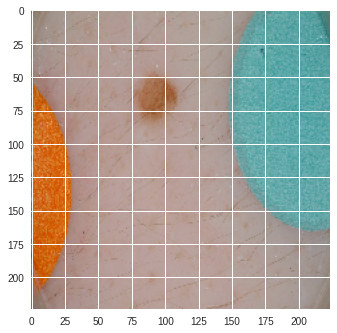

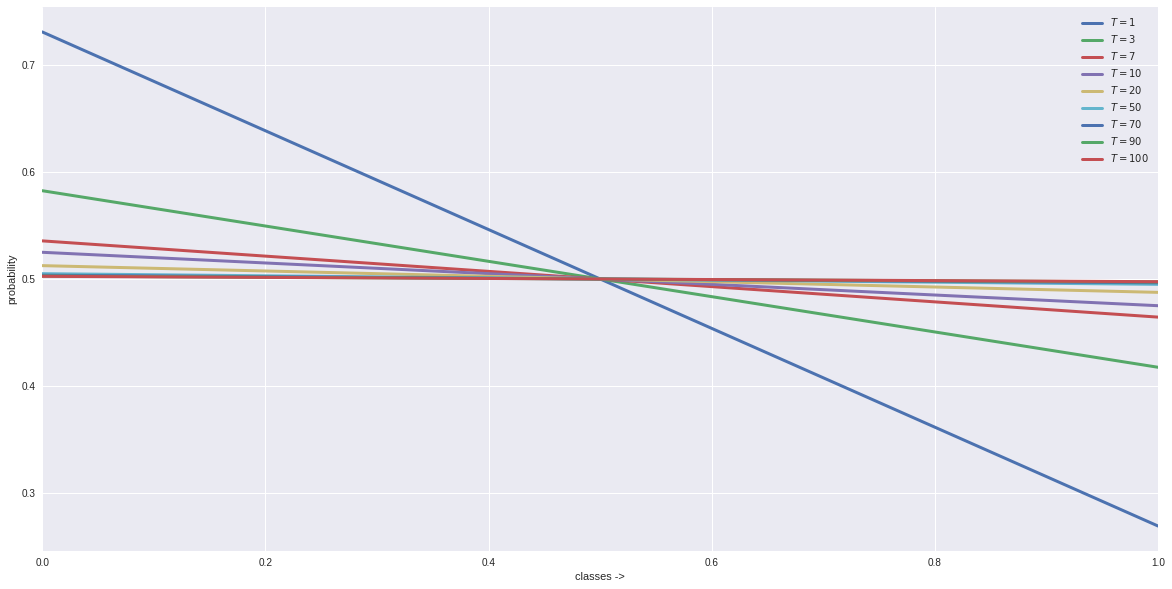

In [ ]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(x_train[122].reshape(1,224,224,3))
print(softmax(intermediate_output))
print('\n')

pixels = x_train[122]
pixels = pixels.reshape((224, 224, 3))
plt.imshow(pixels)
plt.show()
print('\n')

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize = (20, 10));

temperature = [1,3,7,10,20,50,70,90,100]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=3);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 1]);
plt.show()

In [ ]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
effmodel.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = effmodel.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model as mobileNet
effmodel = Model(effmodel.input, output)

effmodel.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
module_wrapper_6_input (InputLa [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
module_wrapper_6 (ModuleWrapper (None, 7, 7, 1280)   4049571     module_wrapper_6_input[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_6 (Glo (None, 1280)         0           module_wrapper_6[0][0]           
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 1280)         0           global_average_pooling2d_6[0][0] 
____________________________________________________________________________________________

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function
nb_classes = 2
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

effmodel.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] 
  )

In [ ]:
# Train the student model with EfficientB0
epochs = 20
batch_size = 64
effmodel_student_his = effmodel.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 66s 635ms/step - loss: 0.0789 - acc: 0.4415 - val_loss: 0.0683 - val_acc: 0.5857
Epoch 2/20
88/88 [==============================] - 53s 606ms/step - loss: 0.0787 - acc: 0.4431 - val_loss: 0.0705 - val_acc: 0.5400
Epoch 3/20
88/88 [==============================] - 53s 605ms/step - loss: 0.0758 - acc: 0.4789 - val_loss: 0.0726 - val_acc: 0.4957
Epoch 4/20
88/88 [==============================] - 53s 608ms/step - loss: 0.0759 - acc: 0.4782 - val_loss: 0.0726 - val_acc: 0.5036
Epoch 5/20
88/88 [==============================] - 53s 603ms/step - loss: 0.0746 - acc: 0.4956 - val_loss: 0.0720 - val_acc: 0.5243
Epoch 6/20
88/88 [==============================] - 54s 610ms/step - loss: 0.0732 - acc: 0.5175 - val_loss: 0.0711 - val_acc: 0.5271
Epoch 7/20
88/88 [==============================] - 54s 608ms/step - loss: 0.0726 - acc: 0.5257 - val_loss: 0.0700 - val_acc: 0.5500
Epoch 8/20
88/88 [==============================] - 53s 605ms/step - 

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(effmodel_student_his.history['acc'])
plt.plot(effmodel_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(effmodel_student_his.history['loss'])
plt.plot(effmodel_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [ ]:
Y_val_pred = effmodel.predict(x_val)
print(f'The EfficientNetB0 model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The EfficientNetB0 model Accuracy on the Validation Set: 0.7714285714285715


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = effmodel.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.72361743 0.27638257 0.5240433  0.47595662]
 [0.7053224  0.29467764 0.5218055  0.47819453]
 [0.3546685  0.6453315  0.48503995 0.51496005]
 ...
 [0.47235277 0.5276472  0.4972325  0.50276756]
 [0.40339226 0.59660774 0.49021748 0.5097825 ]
 [0.29346752 0.7065325  0.47804907 0.52195096]]

Time:  4.987631175000388 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Student model with EfficientNetB0 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Student model with EfficientNetB0 on the Test set is: 0.8206666666666667


In [ ]:
# Print the classification report
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1500
           1       0.85      0.78      0.81      1500

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

---

**END**